In [13]:
import math
import numpy as np
import matplotlib.pyplot as plt
import graphviz
%matplotlib inline

In [14]:
class Value:

    def __init__(self,data,_children=(), _op='', label=''):
        self.data = data
        self.grad=0  ## initually gradiant is zero 
        self._backward = lambda: None
        self._prev=set(_children)
        self._op=_op
        self.label=label
    
    def __repr__(self):
        return f"Value(data={self.data})"



    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out=Value(self.data+ other.data, (self, other),'+')
        
        def _backward():

            ''' gradient is transfered to it's children c=a+b 
                c.grad will pass to a.grad and b.grad
            '''
            self.grad+=1*out.grad
            other.grad+=1*out.grad
        out._backward=_backward
        
        return out
    
    
    def __neg__(self):
        return self*-1
    

    def __sub__(self, other):
        return self +(-other)
        

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out=Value(self.data*other.data, (self, other),'*')

        def _backward():
            ''' gradient will pass like chain rule c=a * b
                a.grad will be b * c.grad
            '''
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad  
        out._backward=_backward    
        
        return out
    

    
    def __rmul__(self, other): ## self + other
        return self *other
    
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)),  "only supporting int/float powers"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad  #-1* (self**-2)*out.grad"
        out._backward = _backward

        return out

    def __truediv__(self, other): # self / other
        return self * other**-1

    
    
    def exp(self):
        x = self.data
        out =Value(math(exp(x), (self, ), 'exp'))

        def _backward():
            self.grad += out.data * out.grad 
        out._backward=_backward 


    def tanh(self):
        x=self.data
        t=(math.exp(2*x)-1)/((math.exp(2*x)+1))
        out=Value(t, (self, ), 'tanh') ## (self,) makes it a 1-element tuple, which can be iterated over later

        def _backward():
            self.grad += (1-t**2)*out.grad
        out._backward=_backward

        return out
    
    def backward(self):

        topo=[]

        visited =set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad= 1.0
        for node in reversed(topo):
            node._backward()



### visualization function

In [ ]:


from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)
 
  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

### The neuron

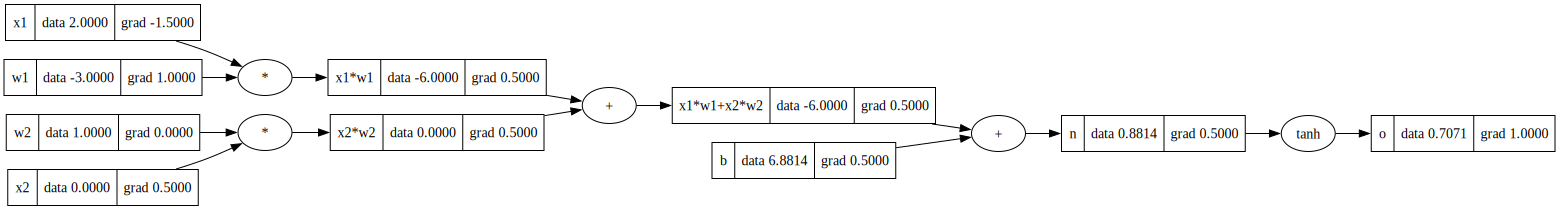

In [20]:
#x1, x2 are inputs of the neurons
x1=Value(2,label='x1')
x2=Value(0,label='x2')

## w1, w2 are weights of the neurons
w1=Value(-3,label='w1')
w2=Value(1,label='w2')


## bias for the single AN
b=Value(6.88137, label='b')


x1w1=x1*w1
x1w1.label='x1*w1'

x2w2=x2*w2
x2w2.label='x2*w2'

x1w1x2w2=x1w1+x2w2
x1w1x2w2.label='x1*w1+x2*w2'

n=x1w1x2w2+b
n.label='n'

o=n.tanh()
o.label='o'

## finally the neuron
o.backward()
draw_dot(o)


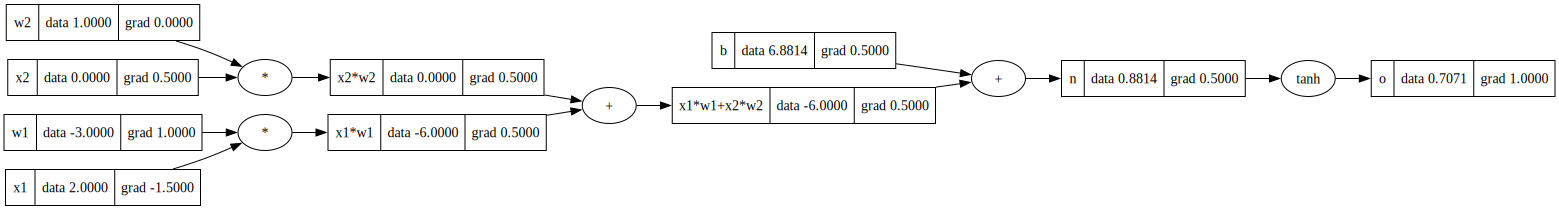

In [ ]:


draw_dot(o)

### Pytorch implementation

In [24]:
import torch

# Check if CUDA is available
cuda_available = torch.cuda.is_available()
print("CUDA Available:", cuda_available)


CUDA Available: False


In [27]:
x1 = torch.Tensor([2.0]).double()                
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                
w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  
b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item()) ## give only the value without the tensor
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [30]:
x1.grad.item()

-1.5000003851533106

### Starting MLP